<a href="https://colab.research.google.com/github/erlichsefi/ScrapeAnything/blob/main/browser_base_translation%20/%20JavaScript%20Converting%20Robust%20Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Converting sites to dataframe

# first: install selenium & chromium

In [1]:
# According to: https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com
%%capture
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium
apt install chromium-chromedriver
pip install pandas

In [62]:
script_with_logs = """
// Get all elements in the HTML page
const elements = document.getElementsByTagName('*');

// Create an array to store the element details
const elementDetails = [];

// Iterate through each element
for (let i = 0; i < elements.length; i++) {
  const element = elements[i];

  // Get the bounding rectangle of the element
  const rect = element.getBoundingClientRect();

  // Get the text content of the element
  const textContent = element.textContent;

  // Get the tooltip value if it exists
  const tooltip = element.hasAttribute('title') ? element.getAttribute('title') : '';

  // Get the aria-label value
  const ariaLabel = (element.hasAttribute('aria-label') ? element.getAttribute('aria-label') : '');

  // Get the nodeName
  const e_type = element.nodeName;

  // Get the data-initial-value
  const data_initial_value = (element.hasAttribute('data-initial-value') ? element.getAttribute('data-initial-value') : '')

  // Get innerText
  const innerText = element.innerText

  // Store the element, its bounding rectangle, text content, and tooltip details
  const elementInfo = {
    element: element,
    rect: rect,
    textContent: textContent !== undefined ? textContent.trim().replaceAll(",",";"): "",
    ariaLabel: ariaLabel.replaceAll(",",";"),
    tooltip: tooltip.replaceAll(",",";"),
    e_type: e_type  !== undefined ? e_type.replaceAll(",",";"): "",
    data_initial_value: data_initial_value.replaceAll(",",";"),
    innerText: innerText !== undefined ? innerText.replaceAll(",",";"): "",
  };

  const viewpointscroll = window.pageYOffset || document.documentElement.scrollTop;
  const viewportHeight = window.innerheight || document.documentElement.clientHeight;

  if (elementInfo.rect !== undefined && elementInfo.rect.width > 0 && elementInfo.rect.height > 0 && elementInfo.rect.top >= viewpointscroll && elementInfo.rect.bottom < (viewpointscroll+viewportHeight)){
    if (elementInfo.innerText != '' || elementInfo.data_initial_value != '' || elementInfo.tooltip != '' || elementInfo.textContent != '' || elementInfo.ariaLabel != ''){
      elementDetails.push(elementInfo);
    }

  }
}

let parents = elementDetails.map(e => e.element.parentElement);
let withoutParents = elementDetails.filter(elementDetail => !( parents.includes(elementDetail.element)));

// Display the element details
console.log("X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value");
console.log(withoutParents.map( e=> e.rect.x+","+e.rect.y+","+e.rect.top+","+e.rect.bottom+","+e.rect.left+","+e.rect.right+","+e.rect.width+","+e.rect.height+","+e.e_type+","+e.textContent+","+e.tooltip+","+e.ariaLabel+","+e.data_initial_value).join("\\n"));
"""

In [54]:
def write_to_text(filename,logs,error):
  with open(filename, 'w') as f:
    f.write(f"error={error}\n")
    f.write('\n'.join(logs))

def draw_all_rec_on_screenshot(file_name,list_of_elements):
  from PIL import Image, ImageDraw
  # Load the screenshot image
  screenshot = Image.open(file_name)
  # Create a drawing object
  draw = ImageDraw.Draw(screenshot)

  for _,elements in list_of_elements.iterrows():
    #print(elements)
    # x = elements['X']
    # y = elements['X']
    top = elements['Top']
    bottom = elements['Bottom']
    left = elements['Left']
    right = elements['Right']
    # width = elements['Width']
    # height = elements['Height']

    # Draw a rectangle on the screenshot image
    draw.rectangle([(left, top), (right, bottom)], outline='red')

    # Save the modified screenshot with the drawn rectangle
  screenshot.save(f"boxes_{file_name}")

In [55]:
def web_driver_to_image(wd,prefix=""):
  import re
  import os
  from urllib.parse import urlparse, urlunparse

  url = wd.current_url
  # Parse the URL
  parsed_url = urlparse(url)

  # Remove the query parameters
  clean_url = urlunparse((parsed_url.scheme, parsed_url.netloc, parsed_url.path, "", "", ""))
  file_name = re.sub(r'[^a-zA-Z0-9_-]', '_', clean_url)
  file_name = f"{prefix}{file_name}"

  wd.save_screenshot(f"{file_name}.png")
  return file_name

def get_browser():
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service

    # restart the browser
    service = Service(executable_path=r'/usr/bin/chromedriver')
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless=new')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.headless = True
    wd = webdriver.Chrome(service=service,options=chrome_options)

    return wd

def screen_to_table(wd,url,raw=False):

  import pandas as pd
  import io

  for timeout in range(10,60,20):
    try:
      wd.set_page_load_timeout(timeout)
      wd.implicitly_wait(timeout)  # Set a timeout of 10 seconds
      wd.get(url)
      break

    except Exception:
      pass

  file_name = web_driver_to_image(wd)

  script = f"""
  var consoleLogs = [];
  var originalLog = console.log;
  console.log = function(message) {{
      consoleLogs.push(message);
      originalLog.apply(console, arguments);
  }};

  {script_with_logs}

  return consoleLogs;
  """

  logs = wd.execute_script(script)

  if not raw:
    df = pd.read_csv(io.StringIO("\n".join(logs)), sep=",")
    draw_all_rec_on_screenshot(f"{file_name}.png",df)
  else:
    df = logs
  #wd.close()
  return file_name,df

In [65]:
# wd = get_browser()
# df = screen_to_table(wd,"https://www.bloomberg.com")

In [69]:
news_sites = [
    "https://www.n12.co.il/",
    "https://www.cnn.com",
    "https://www.bbc.co.uk/news",
    "https://www.nytimes.com",
    "https://www.aljazeera.com",
    "https://www.reuters.com",
    "https://www.theguardian.com",
    "https://www.foxnews.com",
    "https://www.nbcnews.com",
    "https://www.bloomberg.com",
    "https://apnews.com",
    "https://www.huffpost.com",
    "https://www.usatoday.com",
    "https://www.washingtonpost.com",
    "https://www.wsj.com",
    "https://abcnews.go.com",
    "https://www.buzzfeednews.com",
    "https://www.cbsnews.com",
    "https://www.npr.org",
    "https://www.ft.com",
    "https://www.independent.co.uk",
]

In [70]:
wd = get_browser()

for url in news_sites:
  print(f" ---- URL = {url} ---- ")

  try:
    file_name,df = screen_to_table(wd,url)
    csv_file_name = f"{file_name}.csv"
    screenshot_file_name = f"{file_name}.png"
    df.to_csv(csv_file_name)

    print(f"screenshot_file_name = {screenshot_file_name}.")
    print(f"Parsing was sucsessful, csv_file_name = {csv_file_name}.")
  except Exception as e:
    file_name,df = screen_to_table(wd,url,raw=True)
    txt_file_name = f"{file_name}.txt"
    write_to_text(txt_file_name,df,e)


    print(f"screenshot_file_name = {screenshot_file_name}.")
    print(f"Parsing was un-sucsessful, txt_file_name = {txt_file_name}.")

  print(f"please make sure all text in screenshot is explained by output file")

<ipython-input-55-e0cde5318047>:27: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


 ---- URL = https://www.n12.co.il/ ---- 
screenshot_file_name = https___www_n12_co_il_.png.
Parsing was sucsessful, csv_file_name = https___www_n12_co_il_.csv.
please make sure all text in screenshot is explained by output file
 ---- URL = https://www.cnn.com ---- 
screenshot_file_name = https___www_cnn_com_.png.
Parsing was sucsessful, csv_file_name = https___www_cnn_com_.csv.
please make sure all text in screenshot is explained by output file
 ---- URL = https://www.bbc.co.uk/news ---- 
screenshot_file_name = https___www_bbc_com_news.png.
Parsing was sucsessful, csv_file_name = https___www_bbc_com_news.csv.
please make sure all text in screenshot is explained by output file
 ---- URL = https://www.nytimes.com ---- 
screenshot_file_name = https___www_nytimes_com_.png.
Parsing was sucsessful, csv_file_name = https___www_nytimes_com_.csv.
please make sure all text in screenshot is explained by output file
 ---- URL = https://www.aljazeera.com ---- 
screenshot_file_name = https___www_alj

# Here is some issues found in manual analysis

In [71]:
def describe(site):
  from IPython.display import Image, display
  display(Image(filename=f"boxes_{site}.png"))

  import pandas as pd
  return pd.read_csv(f"{site}.csv")

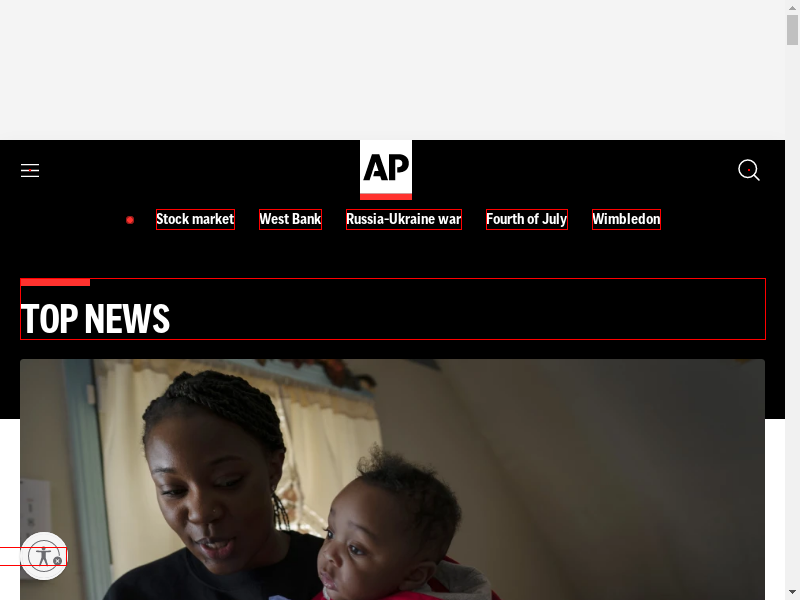

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,-134.0,547.0,547.0,565.0,-134.0,66.0,200,18,DIV,Enable accessibility,NaN,NaN,NaN
1,1,29.0,169.5,169.5,170.5,29.0,30.0,1,1,SPAN,Menu,NaN,NaN,NaN
2,2,748.5,169.5,169.5,170.5,748.5,749.5,1,1,SPAN,Show Search,NaN,NaN,NaN
3,3,-340.0,290.0,290.0,308.0,-340.0,-318.0,22,18,A,U.S.,NaN,NaN,NaN
4,4,-340.0,331.0,331.0,349.0,-340.0,-295.0,45,18,A,World,NaN,NaN,NaN
5,5,-57.0,328.0,328.0,352.0,-57.0,-35.0,22,24,BUTTON,NaN,NaN,More,NaN
6,6,-340.0,375.0,375.0,393.0,-340.0,-285.0,55,18,A,Politics,NaN,NaN,NaN
7,7,-57.0,372.0,372.0,396.0,-57.0,-35.0,22,24,BUTTON,NaN,NaN,More,NaN
8,8,-340.0,416.0,416.0,434.0,-340.0,-303.0,37,18,A,Video,NaN,NaN,NaN
9,9,-340.0,454.0,454.0,472.0,-340.0,-271.0,69,18,A,Spotlight,NaN,NaN,NaN


In [72]:
# here we are missing the menu and search icon
describe("https___apnews_com_")

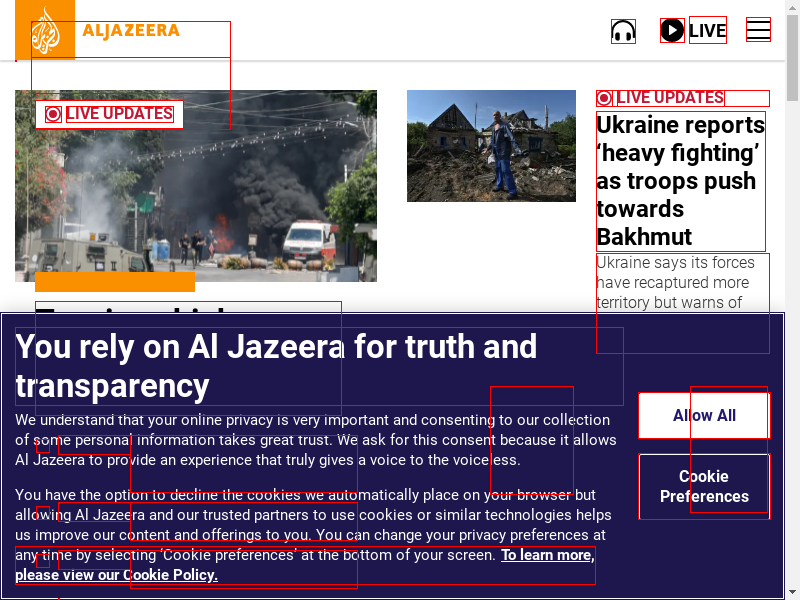

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,31.00000,21.000,21.000,22.000,31.00000,32.000000,1.000000,1,H2,Skip links,NaN,NaN,NaN
1,1,31.00000,21.000,21.000,57.000,31.00000,230.000000,199.000000,36,A,Skip to Featured Content,NaN,NaN,NaN
2,2,31.00000,57.000,57.000,93.000,31.00000,230.000000,199.000000,36,A,Skip to Content Feed,NaN,NaN,NaN
3,3,31.00000,93.000,93.000,129.000,31.00000,230.000000,199.000000,36,A,Skip to Most Read,NaN,NaN,NaN
4,4,15.00000,60.000,60.000,61.000,15.00000,16.000000,1.000000,1,H1,Al Jazeera; link to home page,NaN,NaN,NaN
5,5,611.00000,19.500,19.500,43.500,611.00000,635.000000,24.000000,24,svg,Audio Hub,NaN,NaN,NaN
6,6,660.00000,18.000,18.000,42.000,660.00000,684.000000,24.000000,24,svg,play,NaN,NaN,NaN
7,7,689.00000,16.500,16.500,43.500,689.00000,726.000000,37.000000,27,H2,Live,NaN,NaN,NaN
8,8,746.00000,17.500,17.500,41.500,746.00000,770.000000,24.000000,24,svg,Show navigation menu,NaN,NaN,NaN
9,9,15.00000,60.000,60.000,61.000,15.00000,16.000000,1.000000,1,H2,Featured Content,NaN,NaN,NaN


In [73]:
# something with the boxes not right
describe("https___www_aljazeera_com_")

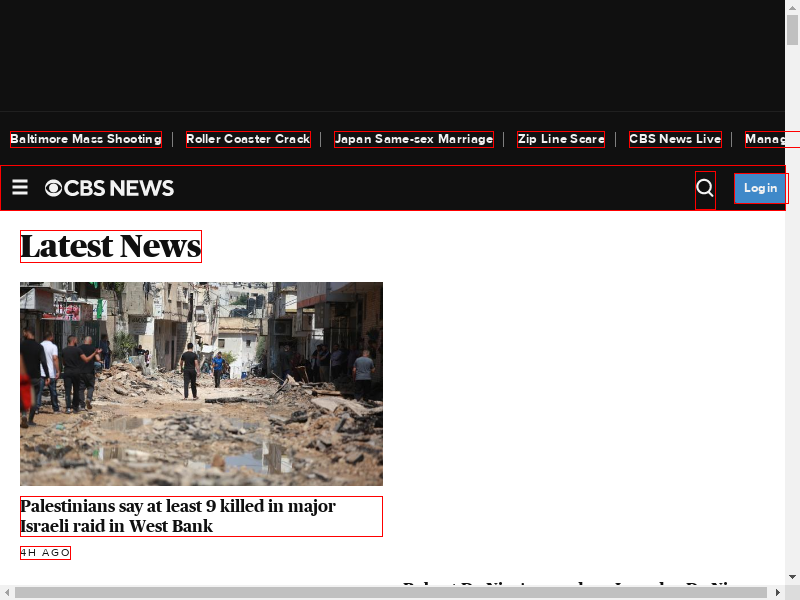

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,10,131.000000,131.000000,147.000000,10.000000,161.906250,151.906250,16.0,SPAN,Baltimore Mass Shooting,NaN,NaN,NaN
1,1,186.21875,131.000000,131.000000,147.000000,186.218750,310.218750,124.000000,16.0,SPAN,Roller Coaster Crack,NaN,NaN,NaN
2,2,334.53125,131.000000,131.000000,147.000000,334.531250,493.437500,158.906250,16.0,SPAN,Japan Same-sex Marriage,NaN,NaN,NaN
3,3,517.75,131.000000,131.000000,147.000000,517.750000,604.953125,87.203125,16.0,SPAN,Zip Line Scare,NaN,NaN,NaN
4,4,629.265625,131.000000,131.000000,147.000000,629.265625,721.171875,91.906250,16.0,SPAN,CBS News Live,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,61,695,171.109375,171.109375,209.109375,695.000000,715.000000,20.000000,38.0,A,Search,NaN,NaN,NaN
62,62,734,173.109375,173.109375,203.109375,734.000000,788.000000,54.000000,30.0,A,Login,NaN,NaN,NaN
63,63,20,230.109375,230.109375,262.109375,20.000000,201.000000,181.000000,32.0,H3,Latest News,NaN,NaN,NaN
64,64,20,496.015625,496.015625,536.015625,20.000000,382.500000,362.500000,40.0,H4,Palestinians say at least 9 killed in major Is...,NaN,NaN,NaN


In [74]:
# we are missing the menu
describe("https___www_cbsnews_com_")

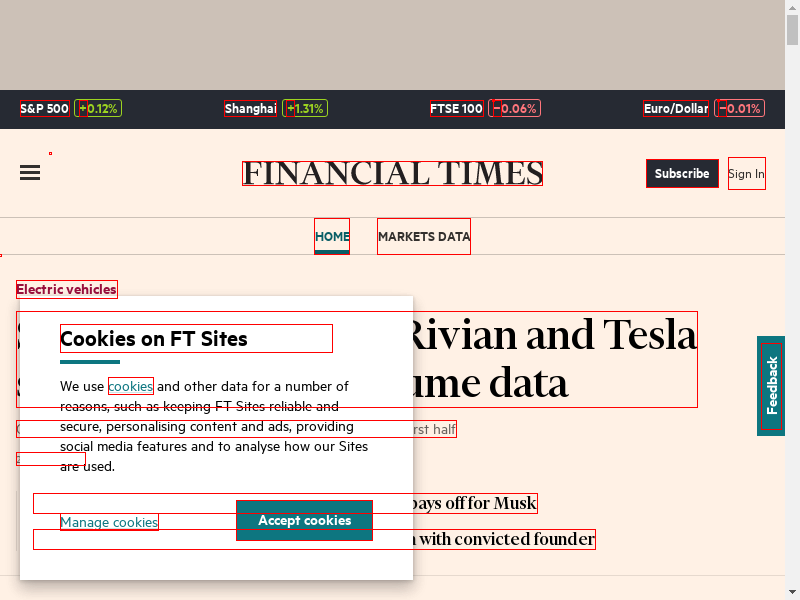

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,-9999.00000,16,16,50.000000,-9999.00000,-9845.171875,153.828125,34.000000,A,Accessibility help,NaN,NaN,NaN
1,1,-9999.00000,16,16,50.000000,-9999.00000,-9840.687500,158.312500,34.000000,A,Skip to navigation,NaN,NaN,NaN
2,2,-9999.00000,16,16,50.000000,-9999.00000,-9861.156250,137.843750,34.000000,A,Skip to content,NaN,NaN,NaN
3,3,-9999.00000,16,16,50.000000,-9999.00000,-9872.718750,126.281250,34.000000,A,Skip to footer,NaN,NaN,NaN
4,4,20.00000,100,100,116.000000,20.00000,69.000000,49.000000,16.000000,SPAN,S&P 500,NaN,NaN,NaN
5,5,79.00000,100,100,116.000000,79.00000,87.000000,8.000000,16.000000,SPAN,+,NaN,NaN,NaN
6,6,224.65625,100,100,116.000000,224.65625,276.656250,52.000000,16.000000,SPAN,Shanghai,NaN,NaN,NaN
7,7,286.65625,100,100,116.000000,286.65625,294.656250,8.000000,16.000000,SPAN,+,NaN,NaN,NaN
8,8,430.31250,100,100,116.000000,430.31250,483.312500,53.000000,16.000000,SPAN,FTSE 100,NaN,NaN,NaN
9,9,492.31250,99,99,101.000000,492.31250,494.312500,2.000000,2.000000,SPAN,Minus,NaN,NaN,NaN


In [75]:
# the scaner see the text behind the cookie popup, can we prevent him?
# also, why we don't find the cookie text box?
describe("https___www_ft_com_")

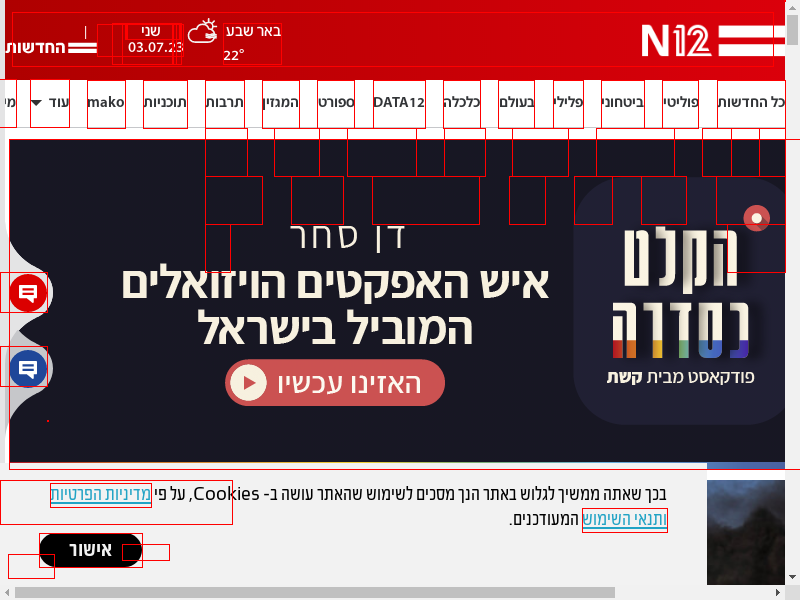

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,12,12.000,12.000,66.000000,12.000000,773.000000,761.000000,54.000000,DIV,Popup heading,NaN,NaN,NaN
1,1,8,554.000,554.000,578.000000,8.000000,54.000000,46.000000,24.000000,BUTTON,Close,NaN,NaN,NaN
2,2,47.5,420.000,420.000,420.700012,47.500000,48.200001,0.700001,0.700012,SPAN,נגישות,NaN,NaN,NaN
3,3,784,0.000,0.000,1.000000,784.000000,785.000000,1.000000,1.000000,DIV,"שִׂים לֵב: בְּאֲתָר זֶה מֻפְעֶלֶת מַעֲרֶכֶת ""נ...",NaN,NaN,NaN
4,4,112.734375,23.875,23.875,64.000000,112.734375,181.234375,68.500000,40.125000,SPAN,תל אביב - יפו 25°,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,78,0,272.500,272.500,312.500000,0.000000,47.000000,47.000000,40.000000,DIV,צ'אט הכתבים,NaN,NaN,NaN
79,79,0,346.000,346.000,386.000000,0.000000,47.000000,47.000000,40.000000,DIV,צ'אט הספורט,NaN,NaN,NaN
80,80,50.25,483.000,483.000,507.000000,50.250000,151.250000,101.000000,24.000000,A,מדיניות הפרטיות,NaN,NaN,NaN
81,81,582.25,508.000,508.000,532.000000,582.250000,667.250000,85.000000,24.000000,A,ותנאי השימוש,NaN,NaN,NaN


In [76]:
# what are those boxes in the ad
describe("https___www_n12_co_il_")

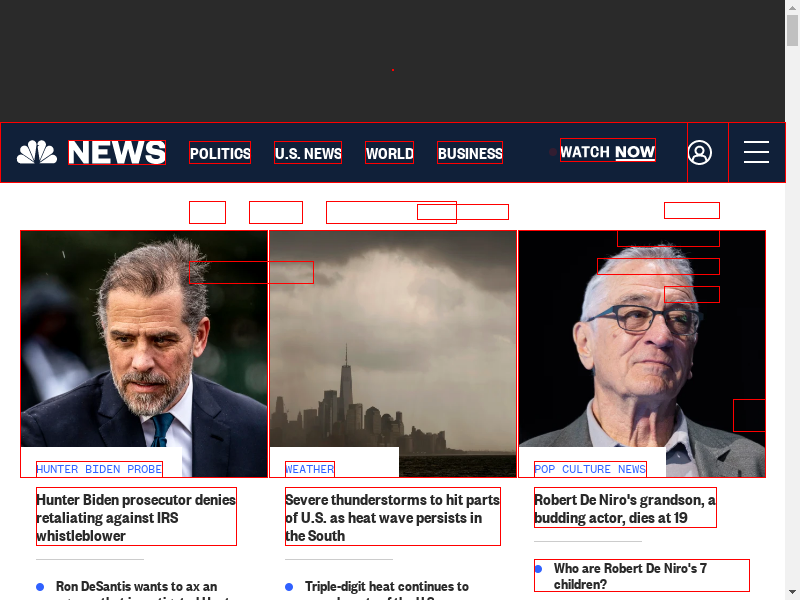

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,392.000000,69.500000,69.500000,70.500000,392.000000,393.000000,1.000000,1.00000,IFRAME,NaN,3rd party ad content,Advertisement,NaN
1,1,68.000000,140.000000,140.000000,164.000000,68.000000,165.796875,97.796875,24.00000,svg,NBC News Logo,NaN,NaN,NaN
2,2,189.796875,141.000000,141.000000,163.000000,189.796875,250.796875,61.000000,22.00000,A,Politics,NaN,NaN,NaN
3,3,274.796875,141.000000,141.000000,163.000000,274.796875,341.796875,67.000000,22.00000,A,U.S. News,NaN,NaN,NaN
4,4,365.796875,141.000000,141.000000,163.000000,365.796875,413.796875,48.000000,22.00000,A,World,NaN,NaN,NaN
5,5,437.796875,141.000000,141.000000,163.000000,437.796875,502.796875,65.000000,22.00000,A,Business,NaN,NaN,NaN
6,6,189.796875,201.000000,201.000000,223.000000,189.796875,225.796875,36.000000,22.00000,A,Tech,NaN,NaN,NaN
7,7,249.796875,201.000000,201.000000,223.000000,249.796875,302.796875,53.000000,22.00000,A,Health,NaN,NaN,NaN
8,8,326.796875,201.000000,201.000000,223.000000,326.796875,456.796875,130.000000,22.00000,A,Culture & trends,NaN,NaN,NaN
9,9,189.796875,261.000000,261.000000,283.000000,189.796875,313.796875,124.000000,22.00000,A,NBC News Tipline,NaN,NaN,NaN


In [77]:
# again, boxs behind the ad
describe("https___www_nbcnews_com_")

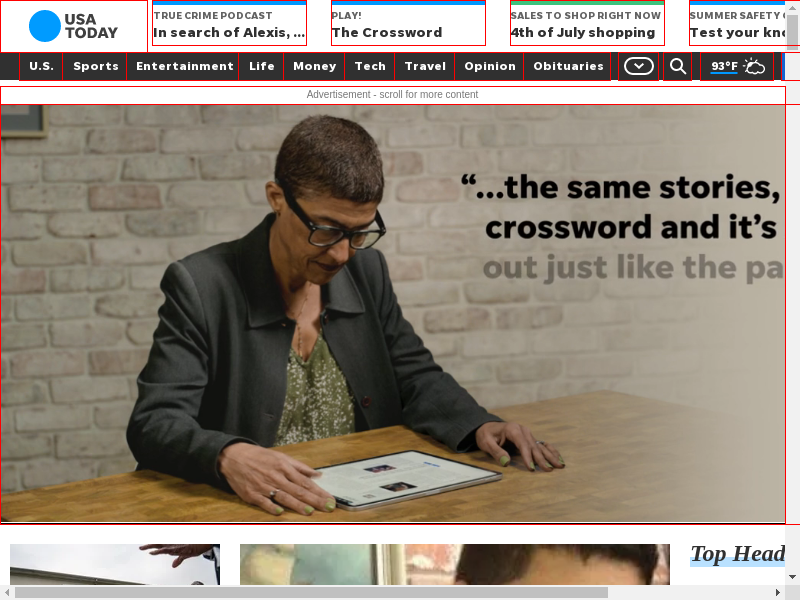

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,0.000000,0,0,52,0.000000,147.140625,147.140625,52,A,NaN,NaN,USA TODAY,NaN
1,1,152.500000,0,0,45,152.500000,306.734375,154.234375,45,A,In search of Alexis; 7 🎙️,NaN,NaN,NaN
2,2,331.406250,0,0,45,331.406250,485.640625,154.234375,45,A,The Crossword,NaN,NaN,NaN
3,3,510.312500,0,0,45,510.312500,664.546875,154.234375,45,A,4th of July shopping,NaN,NaN,NaN
4,4,689.218750,0,0,45,689.218750,843.453125,154.234375,45,A,Test your knowledge,NaN,NaN,NaN
5,5,19.000000,52,52,80,19.000000,62.656250,43.656250,28,A,U.S.,NaN,NaN,NaN
6,6,62.656250,52,52,80,62.656250,126.171875,63.515625,28,A,Sports,NaN,NaN,NaN
7,7,126.171875,52,52,80,126.171875,238.875000,112.703125,28,A,Entertainment,NaN,NaN,NaN
8,8,238.875000,52,52,80,238.875000,283.468750,44.593750,28,A,Life,NaN,NaN,NaN
9,9,283.468750,52,52,80,283.468750,344.140625,60.671875,28,A,Money,NaN,NaN,NaN


In [78]:
# one big ad
describe("https___www_usatoday_com_")